In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
from glob import glob


# 850 hPa MSLP

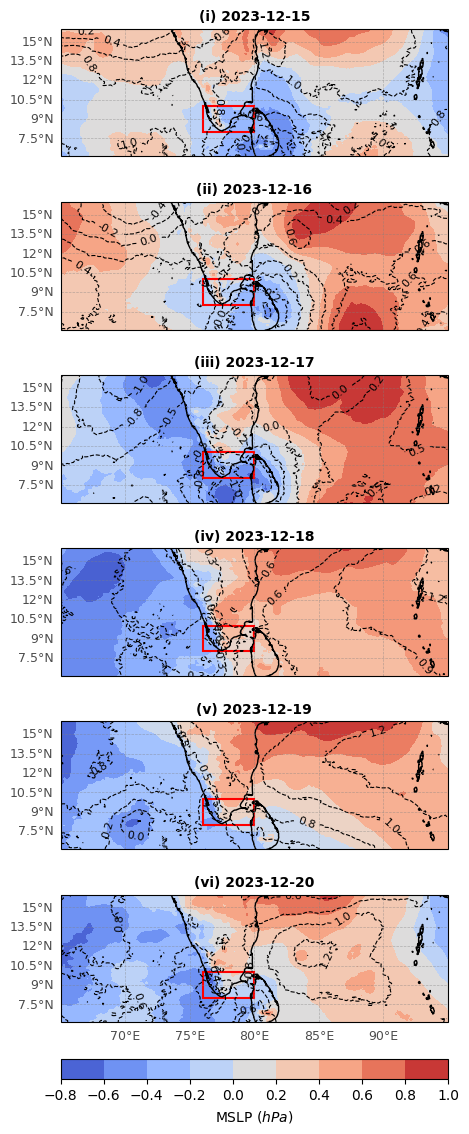

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from glob import glob
from matplotlib.patches import Rectangle

def plot_mslp_with_gph_anomaly(
    data_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/MSLP/ncum_imdaa_reanl_HR_PRMSL-msl_2023121500-2023122123.nc",
    gph_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum_imdaa_reanl_HR_HGT-prl_2023121500-2023122121.nc",
    date_range=[f"2023-12-{j}" for j in range(15, 21)],
    julian_mean=None,
    julian_mean_gph=None,
    height=850,
    output_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/Figures/MSLP_GPH_850.png"
):
    # Read the datasets
    data = xr.open_dataset(data_path)
    data_gph = xr.open_dataset(gph_path)
    
    #define tick intervals 
    yticks = np.arange(5, 21, 3)   # Latitude ticks every 3 degrees
    
    # Set lat/lon bounds
    min_lon, max_lon = 65, 95
    min_lat, max_lat = 6.1, 16
    
    # Create the figure and axes for subplots
    fig, axes = plt.subplots(
        nrows=len(date_range), ncols=1, figsize=(5, 16), 
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Shared colorbar parameters
    levels = 8 
    cmap = 'coolwarm'
    value=[]
    labels = ['(i)', '(ii)', '(iii)', '(iv)', '(v)', '(vi)']
    
    # Ensure axes is a list for compatibility
    if len(date_range) == 1:
        axes = [axes]
    
    # Loop over dates
    for idx, date in enumerate(date_range):
        ax = axes[idx]
        
        # Select data for the specific date and region
        date_data = data.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon)
        )['PRMSL_msl'].squeeze()  # Extract the variable and squeeze
        
        date_data_gph = data_gph.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon), 
            plevel=height
        )['HGT_prl'].squeeze()  # Extract the variable and squeeze
        
        # Extract Julian day
        julian_day = pd.to_datetime(date).dayofyear
        
        # Subset Julian mean values for the specific day
        julian_mean_mslp = julian_mean.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        julian_mean_gph_day = julian_mean_gph.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        # Calculate anomalies
        mslp_anomaly = (date_data - julian_mean_mslp) / 100
        gph_anomaly = (date_data_gph - julian_mean_gph_day) / 10
        
        # Ensure anomalies are 2D (lat, lon)
        mslp_anomaly = mslp_anomaly.mean(dim='time')  # Reduce time dimension if present
        gph_anomaly = gph_anomaly.mean(dim='time')  # Reduce time dimension if present
        
        # Create meshgrid for plotting
        lon, lat = np.meshgrid(mslp_anomaly.longitude.values, 
                               mslp_anomaly.latitude.values)
        
        # Plot MSLP anomaly
        cf = ax.contourf(lon, lat, mslp_anomaly.values, 
                         cmap=cmap, levels=levels,
                         transform=ccrs.PlateCarree())
        
        # Plot GPH anomaly
        cs = ax.contour(lon, lat, gph_anomaly.values,
                        colors='black', linewidths=0.8, linestyles='dashed',
                        transform=ccrs.PlateCarree())
        
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.1f')
        
        
        # Add features to the map
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='#F5F5DC')
        ax.add_feature(cfeature.OCEAN, facecolor='#E0FFFF')
        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())


        # Add a rectangular box
        lon_min, lon_max = 76, 80
        lat_min, lat_max = 8, 10
        box = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                        edgecolor='red', facecolor='none', linewidth=1.5, transform=ccrs.PlateCarree())
        ax.add_patch(box)
        # Add gridlines
        gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels=False
        gl.left_labels=True
                # Apply opacity to y-axis labels
        
        # Manually set left labels
        gl.ylabel_style = {'fontsize': 9, 'alpha': 0.7}
        
            # Only show x-ticks on the last plot
        if idx == len(date_range)-1:
            gl.bottom_labels=True  # Enable x-ticks on the top of the last plot
            gl.xlabel_style = {'fontsize': 9,'alpha': 0.7}
        else:
            gl.bottom_labels=False  # Disable x-ticks on all other plots

        # Title for each subplot
        ax.set_title(f'{labels[idx]} {date}', fontsize=10, fontweight='bold')
        
    cbar = fig.colorbar(cf, ax=axes, orientation='horizontal', 
        label="MSLP ($hPa$)", pad=0.03) 
    # Save the figure
    plt.savefig(f"{output_path}", dpi=300, bbox_inches='tight')

def load_julian_mean(
    paths_mslp=None,
    paths_gph=None,
    height=850
):
    # Load MSLP data
    datasets_mslp = [xr.open_dataset(fp) for fp in paths_mslp]
    data_mslp = xr.concat(datasets_mslp, dim="time")
    data_mslp['time'] = pd.to_datetime(data_mslp['time'].values)
    data_mslp = data_mslp.assign_coords(julian_day=data_mslp['time'].dt.dayofyear)
    julian_mean_mslp = data_mslp['PRMSL_msl'].groupby('julian_day').mean(dim='time')
    
    # Load GPH data
    datasets_gph = [xr.open_dataset(fp).sel(plevel=height) for fp in paths_gph]
    data_gph = xr.concat(datasets_gph, dim="time")
    data_gph['time'] = pd.to_datetime(data_gph['time'].values)
    data_gph = data_gph.assign_coords(julian_day=data_gph['time'].dt.dayofyear)
    julian_mean_gph = data_gph['HGT_prl'].groupby('julian_day').mean(dim='time')
    
    return julian_mean_mslp, julian_mean_gph

# Load Julian Mean values
paths_mslp = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/MSLP/ncum*.nc"))
paths_gph = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum*.nc"))
julian_mean, julian_mean_gph = load_julian_mean(paths_mslp=paths_mslp, paths_gph=paths_gph)

# Plot anomalies
plot_mslp_with_gph_anomaly(julian_mean=julian_mean, julian_mean_gph=julian_mean_gph)


# At 500hPa MSLP


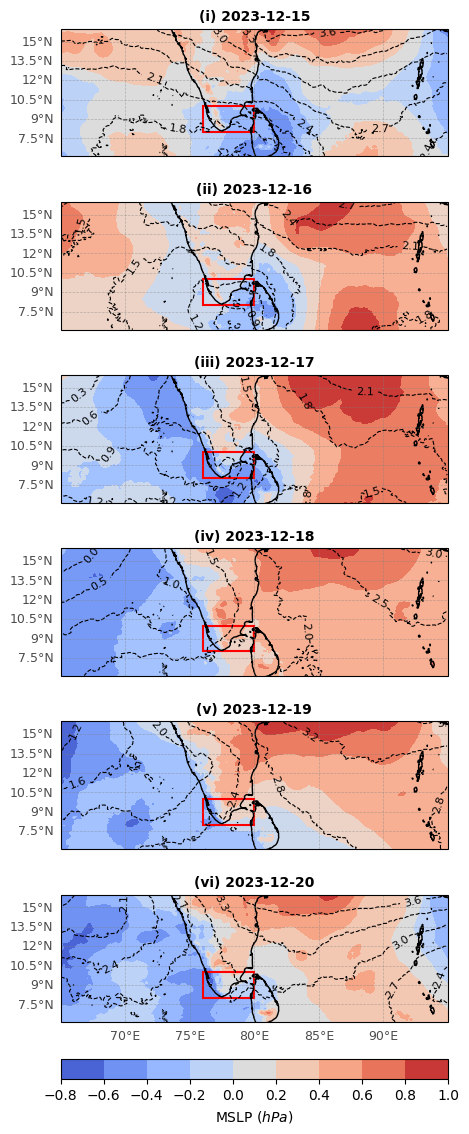

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from glob import glob
from matplotlib.patches import Rectangle

def plot_mslp_with_gph_anomaly(
    data_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/MSLP/ncum_imdaa_reanl_HR_PRMSL-msl_2023121500-2023122123.nc",
    gph_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum_imdaa_reanl_HR_HGT-prl_2023121500-2023122121.nc",
    date_range=[f"2023-12-{j}" for j in range(15, 21)],
    julian_mean=None,
    julian_mean_gph=None,
    height=500,
    output_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/Figures/MSLP_GPH_500.png"
):
    # Read the datasets
    data = xr.open_dataset(data_path)
    data_gph = xr.open_dataset(gph_path)
    
    #define tick intervals 
    yticks = np.arange(5, 21, 3)   # Latitude ticks every 3 degrees
    
    # Set lat/lon bounds
    min_lon, max_lon = 65, 95
    min_lat, max_lat = 6.1, 16
    
    # Create the figure and axes for subplots
    fig, axes = plt.subplots(
        nrows=len(date_range), ncols=1, figsize=(5, 16), 
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Shared colorbar parameters
    levels = 7 
    cmap = 'coolwarm'
    value=[]
    labels = ['(i)', '(ii)', '(iii)', '(iv)', '(v)', '(vi)']
    # Ensure axes is a list for compatibility
    if len(date_range) == 1:
        axes = [axes]
    
    # Loop over dates
    for idx, date in enumerate(date_range):
        ax = axes[idx]
        
        # Select data for the specific date and region
        date_data = data.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon)
        )['PRMSL_msl'].squeeze()  # Extract the variable and squeeze
        
        date_data_gph = data_gph.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon), 
            plevel=height
        )['HGT_prl'].squeeze()  # Extract the variable and squeeze
        
        # Extract Julian day
        julian_day = pd.to_datetime(date).dayofyear
        
        # Subset Julian mean values for the specific day
        julian_mean_mslp = julian_mean.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        julian_mean_gph_day = julian_mean_gph.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        # Calculate anomalies
        mslp_anomaly = (date_data - julian_mean_mslp) / 100
        gph_anomaly = (date_data_gph - julian_mean_gph_day) / 10
        
        # Ensure anomalies are 2D (lat, lon)
        mslp_anomaly = mslp_anomaly.mean(dim='time')  # Reduce time dimension if present
        gph_anomaly = gph_anomaly.mean(dim='time')  # Reduce time dimension if present
        
        # Create meshgrid for plotting
        lon, lat = np.meshgrid(mslp_anomaly.longitude.values, 
                               mslp_anomaly.latitude.values)
        
        # Plot MSLP anomaly
        cf = ax.contourf(lon, lat, mslp_anomaly.values, 
                         cmap=cmap, levels=levels,
                         transform=ccrs.PlateCarree())
        
        # Plot GPH anomaly
        cs = ax.contour(lon, lat, gph_anomaly.values,
                        colors='black', linewidths=0.8, linestyles='dashed',
                        transform=ccrs.PlateCarree())
        
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.1f')
        
        
        # Add features to the map
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='#F5F5DC')
        ax.add_feature(cfeature.OCEAN, facecolor='#E0FFFF')
        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())


        # Add a rectangular box
        lon_min, lon_max = 76, 80
        lat_min, lat_max = 8, 10
        box = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                        edgecolor='red', facecolor='none', linewidth=1.5, transform=ccrs.PlateCarree())
        ax.add_patch(box)
        # Add gridlines
        gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels=False
        gl.left_labels=True
                # Apply opacity to y-axis labels
        
        # Manually set left labels
        gl.ylabel_style = {'fontsize': 9, 'alpha': 0.7}
        
            # Only show x-ticks on the last plot
        if idx == len(date_range)-1:
            gl.bottom_labels=True  # Enable x-ticks on the top of the last plot
            gl.xlabel_style = {'fontsize': 9,'alpha': 0.7}
        else:
            gl.bottom_labels=False  # Disable x-ticks on all other plots

        # Title for each subplot
        ax.set_title(f'{labels[idx]} {date}', fontsize=10,fontweight='bold')
        
    cbar = fig.colorbar(cf, ax=axes, orientation='horizontal', 
        label="MSLP ($hPa$)", pad=0.03) 
    # Save the figure
    plt.savefig(f"{output_path}", dpi=300, bbox_inches='tight')

def load_julian_mean(
    paths_mslp=None,
    paths_gph=None,
    height=500
):
    # Load MSLP data
    datasets_mslp = [xr.open_dataset(fp) for fp in paths_mslp]
    data_mslp = xr.concat(datasets_mslp, dim="time")
    data_mslp['time'] = pd.to_datetime(data_mslp['time'].values)
    data_mslp = data_mslp.assign_coords(julian_day=data_mslp['time'].dt.dayofyear)
    julian_mean_mslp = data_mslp['PRMSL_msl'].groupby('julian_day').mean(dim='time')
    
    # Load GPH data
    datasets_gph = [xr.open_dataset(fp).sel(plevel=height) for fp in paths_gph]
    data_gph = xr.concat(datasets_gph, dim="time")
    data_gph['time'] = pd.to_datetime(data_gph['time'].values)
    data_gph = data_gph.assign_coords(julian_day=data_gph['time'].dt.dayofyear)
    julian_mean_gph = data_gph['HGT_prl'].groupby('julian_day').mean(dim='time')
    
    return julian_mean_mslp, julian_mean_gph

# Load Julian Mean values
paths_mslp = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/MSLP/ncum*.nc"))
paths_gph = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum*.nc"))
julian_mean, julian_mean_gph = load_julian_mean(paths_mslp=paths_mslp, paths_gph=paths_gph)

# Plot anomalies
plot_mslp_with_gph_anomaly(julian_mean=julian_mean, julian_mean_gph=julian_mean_gph)


# Vertical velocity

# 850hPa

ValueError: 'RdGrBu' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

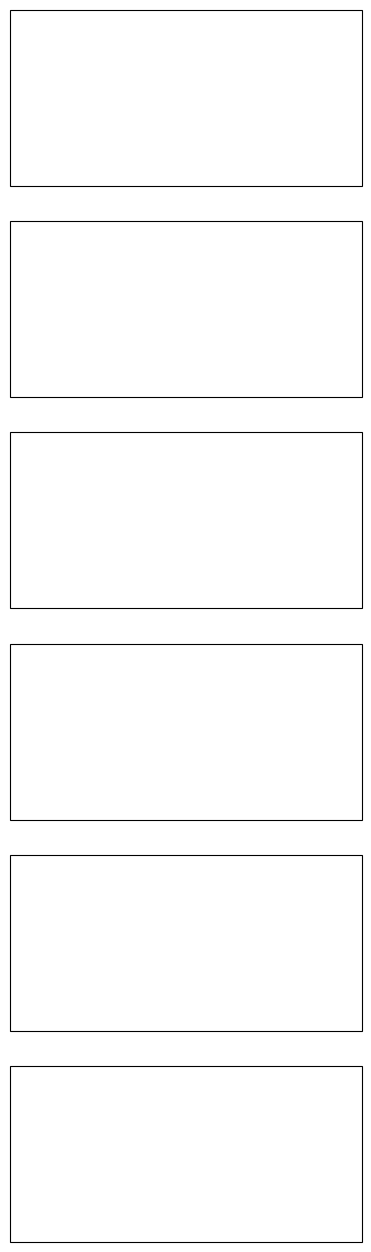

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from glob import glob
from matplotlib.patches import Rectangle

def plot_vv_with_gph_anomaly(
    data_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/VV/ncum_imdaa_reanl_HR_DZDT-prl_2023121500-2023122121.nc",
    gph_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum_imdaa_reanl_HR_HGT-prl_2023121500-2023122121.nc",
    date_range=[f"2023-12-{j}" for j in range(15, 21)],
    julian_mean=None,
    julian_mean_gph=None,
    height=850,
    output_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/Figures/VV_GPH_850.png"
):
    # Read the datasets
    data = xr.open_dataset(data_path)
    data_gph = xr.open_dataset(gph_path)
    
    # Define tick intervals 
    yticks = np.arange(5, 21, 3)
    
    # Set lat/lon bounds
    min_lon, max_lon = 65, 95
    min_lat, max_lat = 6, 16
    
    # Create the figure and axes for subplots
    fig, axes = plt.subplots(nrows=len(date_range), ncols=1, figsize=(5, 16), subplot_kw={'projection': ccrs.PlateCarree()})
    # Shared colorbar parameters
    
    levels = [-0.20,-0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15]
    cmap = 'RdGrBu'
    labels=['(i)', '(ii)', '(iii)', '(iv)', '(v)', '(vi)']
    # Ensure axes is a list for compatibility
    if len(date_range) == 1:
        axes = [axes]
    
    # Loop over dates
    for idx, date in enumerate(date_range):
        ax = axes[idx]
        
        # Select data for the specific date and region
        date_data = data.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon),
            plevel=height
        )['DZDT_prl'].squeeze()
        
        date_data_gph = data_gph.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon), 
            plevel=height
        )['HGT_prl'].squeeze()
        
        # Extract Julian day
        julian_day = pd.to_datetime(date).dayofyear
        
        # Subset Julian mean values for the specific day
        julian_mean_mslp = julian_mean.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        julian_mean_gph_day = julian_mean_gph.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        # Calculate anomalies
        mslp_anomaly = date_data - julian_mean_mslp  # No need to divide by 100 for Celsius
        gph_anomaly = (date_data_gph - julian_mean_gph_day) / 10
        
        # Ensure anomalies are 2D (lat, lon)
        if 'time' in mslp_anomaly.dims:
            mslp_anomaly = mslp_anomaly.mean(dim='time')
        if 'time' in gph_anomaly.dims:
            gph_anomaly = gph_anomaly.mean(dim='time')
        
        # Create meshgrid for plotting
        lon, lat = np.meshgrid(mslp_anomaly.longitude.values, 
                              mslp_anomaly.latitude.values)
        
        # Plot MSLP anomaly
        cf = ax.contourf(lon, lat, mslp_anomaly.values, 
                        cmap=cmap,levels=levels,
                        transform=ccrs.PlateCarree())
        
        # Plot GPH anomaly
        cs = ax.contour(lon, lat, gph_anomaly.values,
                       colors='black', linewidths=0.8, linestyles='dashed',
                       transform=ccrs.PlateCarree())
        
        ax.clabel(cs, inline=True, fontsize=9, fmt='%1.1f')
        
        # Add features to the map
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='#F5F5DC')
        ax.add_feature(cfeature.OCEAN, facecolor='#E0FFFF')
        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Add a rectangular box
        lon_min, lon_max = 76, 80
        lat_min, lat_max = 8, 10
        box = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                       edgecolor='red', facecolor='none', linewidth=1.5, transform=ccrs.PlateCarree())
        ax.add_patch(box)
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        gl.left_labels = True
        
        # Manually set left labels
        gl.ylabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Only show x-ticks on the last plot
        if idx == len(date_range)-1:
            gl.bottom_labels = True
            gl.xlabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Title for each subplot
        ax.set_title(f'{labels[idx]} {date}', fontsize=10,fontweight='bold')
        
    # Add a common colorbar
    cbar = fig.colorbar(cf, ax=axes, orientation='horizontal', 
                    label="Vertical Velocity ($ms^{-1}$)", pad=0.03)
    # Save the figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')


def load_julian_mean(paths_mslp=None, paths_gph=None, height=850):
    """
    Load and process climate data to calculate Julian day means.
    """
    # Load MSLP data
    datasets_mslp = []
    for fp in paths_mslp:
        ds = xr.open_dataset(fp)
        # Select the specific height level first
        if 'plevel' in ds.dims:
            ds = ds.sel(plevel=height)
        datasets_mslp.append(ds)
    
    # Concatenate along time dimension
    data_mslp = xr.concat(datasets_mslp, dim="time")
    data_mslp['time'] = pd.to_datetime(data_mslp['time'].values)
    data_mslp = data_mslp.assign_coords(julian_day=data_mslp['time'].dt.dayofyear)
    julian_mean_mslp = data_mslp['DZDT_prl'].groupby('julian_day').mean(dim='time')
    
    # Load GPH data
    datasets_gph = []
    for fp in paths_gph:
        ds = xr.open_dataset(fp)
        # Select the specific height level first
        if 'plevel' in ds.dims:
            ds = ds.sel(plevel=height)
        datasets_gph.append(ds)
    
    # Concatenate along time dimension
    data_gph = xr.concat(datasets_gph, dim="time")
    data_gph['time'] = pd.to_datetime(data_gph['time'].values)
    data_gph = data_gph.assign_coords(julian_day=data_gph['time'].dt.dayofyear)
    julian_mean_gph = data_gph['HGT_prl'].groupby('julian_day').mean(dim='time')
    
    return julian_mean_mslp, julian_mean_gph

# Load Julian Mean values
paths_mslp = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/VV/ncum*.nc"))
paths_gph = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum*.nc"))
julian_mean, julian_mean_gph = load_julian_mean(paths_mslp=paths_mslp, paths_gph=paths_gph)

# Plot anomalies
plot_vv_with_gph_anomaly(julian_mean=julian_mean, julian_mean_gph=julian_mean_gph)



# VV at 500 hPa

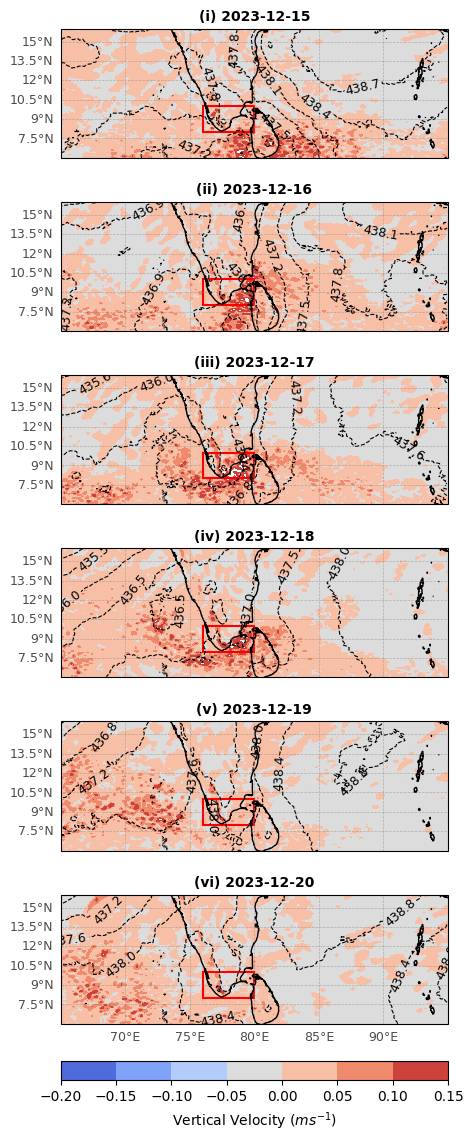

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from glob import glob
from matplotlib.patches import Rectangle

def plot_vv_with_gph_anomaly(
    data_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/VV/ncum_imdaa_reanl_HR_DZDT-prl_2023121500-2023122121.nc",
    gph_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum_imdaa_reanl_HR_HGT-prl_2023121500-2023122121.nc",
    date_range=[f"2023-12-{j}" for j in range(15, 21)],
    julian_mean=None,
    julian_mean_gph=None,
    height=500,
    output_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/Figures/VV_GPH_500.png"
):
    # Read the datasets
    data = xr.open_dataset(data_path)
    data_gph = xr.open_dataset(gph_path)
    
    # Define tick intervals 
    yticks = np.arange(5, 21, 3)
    
    # Set lat/lon bounds
    min_lon, max_lon = 65, 95
    min_lat, max_lat = 6, 16
    
    # Create the figure and axes for subplots
    fig, axes = plt.subplots(nrows=len(date_range), ncols=1, figsize=(5, 16), subplot_kw={'projection': ccrs.PlateCarree()})
    # Shared colorbar parameters
    levels = [-0.20,-0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15]
    cmap = 'coolwarm'
    labels=['(i)', '(ii)', '(iii)', '(iv)', '(v)', '(vi)']
    # Ensure axes is a list for compatibility
    if len(date_range) == 1:
        axes = [axes]
    
    # Loop over dates
    for idx, date in enumerate(date_range):
        ax = axes[idx]
        
        # Select data for the specific date and region
        date_data = data.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon),
            plevel=height
        )['DZDT_prl'].squeeze()
        
        date_data_gph = data_gph.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon), 
            plevel=height
        )['HGT_prl'].squeeze()
        
        # Extract Julian day
        julian_day = pd.to_datetime(date).dayofyear
        
        # Subset Julian mean values for the specific day
        julian_mean_mslp = julian_mean.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        julian_mean_gph_day = julian_mean_gph.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        # Calculate anomalies
        mslp_anomaly = date_data - julian_mean_mslp  # No need to divide by 100 for Celsius
        gph_anomaly = (date_data_gph - julian_mean_gph_day) / 10
        
        # Ensure anomalies are 2D (lat, lon)
        if 'time' in mslp_anomaly.dims:
            mslp_anomaly = mslp_anomaly.mean(dim='time')
        if 'time' in gph_anomaly.dims:
            gph_anomaly = gph_anomaly.mean(dim='time')
        
        # Create meshgrid for plotting
        lon, lat = np.meshgrid(mslp_anomaly.longitude.values, 
                              mslp_anomaly.latitude.values)
        
        # Plot MSLP anomaly
        cf = ax.contourf(lon, lat, mslp_anomaly.values, 
                        cmap=cmap,levels=levels,
                        transform=ccrs.PlateCarree())
        
        # Plot GPH anomaly
        cs = ax.contour(lon, lat, gph_anomaly.values,
                       colors='black', linewidths=0.8, linestyles='dashed',
                       transform=ccrs.PlateCarree())
        
        ax.clabel(cs, inline=True, fontsize=9, fmt='%1.1f')
        
        # Add features to the map
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='#F5F5DC')
        ax.add_feature(cfeature.OCEAN, facecolor='#E0FFFF')
        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Add a rectangular box
        lon_min, lon_max = 76, 80
        lat_min, lat_max = 8, 10
        box = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                       edgecolor='red', facecolor='none', linewidth=1.5, transform=ccrs.PlateCarree())
        ax.add_patch(box)
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        gl.left_labels = True
        
        # Manually set left labels
        gl.ylabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Only show x-ticks on the last plot
        if idx == len(date_range)-1:
            gl.bottom_labels = True
            gl.xlabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Title for each subplot
        ax.set_title(f'{labels[idx]} {date}', fontsize=10,fontweight='bold')
        
    # Add a common colorbar
    cbar = fig.colorbar(cf, ax=axes, orientation='horizontal', 
                    label="Vertical Velocity ($ms^{-1}$)", pad=0.03)
    # Save the figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')


def load_julian_mean(paths_mslp=None, paths_gph=None, height=850):
    """
    Load and process climate data to calculate Julian day means.
    """
    # Load MSLP data
    datasets_mslp = []
    for fp in paths_mslp:
        ds = xr.open_dataset(fp)
        # Select the specific height level first
        if 'plevel' in ds.dims:
            ds = ds.sel(plevel=height)
        datasets_mslp.append(ds)
    
    # Concatenate along time dimension
    data_mslp = xr.concat(datasets_mslp, dim="time")
    data_mslp['time'] = pd.to_datetime(data_mslp['time'].values)
    data_mslp = data_mslp.assign_coords(julian_day=data_mslp['time'].dt.dayofyear)
    julian_mean_mslp = data_mslp['DZDT_prl'].groupby('julian_day').mean(dim='time')
    
    # Load GPH data
    datasets_gph = []
    for fp in paths_gph:
        ds = xr.open_dataset(fp)
        # Select the specific height level first
        if 'plevel' in ds.dims:
            ds = ds.sel(plevel=height)
        datasets_gph.append(ds)
    
    # Concatenate along time dimension
    data_gph = xr.concat(datasets_gph, dim="time")
    data_gph['time'] = pd.to_datetime(data_gph['time'].values)
    data_gph = data_gph.assign_coords(julian_day=data_gph['time'].dt.dayofyear)
    julian_mean_gph = data_gph['HGT_prl'].groupby('julian_day').mean(dim='time')
    
    return julian_mean_mslp, julian_mean_gph

# Load Julian Mean values
paths_mslp = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/VV/ncum*.nc"))
paths_gph = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum*.nc"))
julian_mean, julian_mean_gph = load_julian_mean(paths_mslp=paths_mslp, paths_gph=paths_gph)

# Plot anomalies
plot_vv_with_gph_anomaly(julian_mean=julian_mean, julian_mean_gph=julian_mean_gph)



# Specific Humidity 850hPa

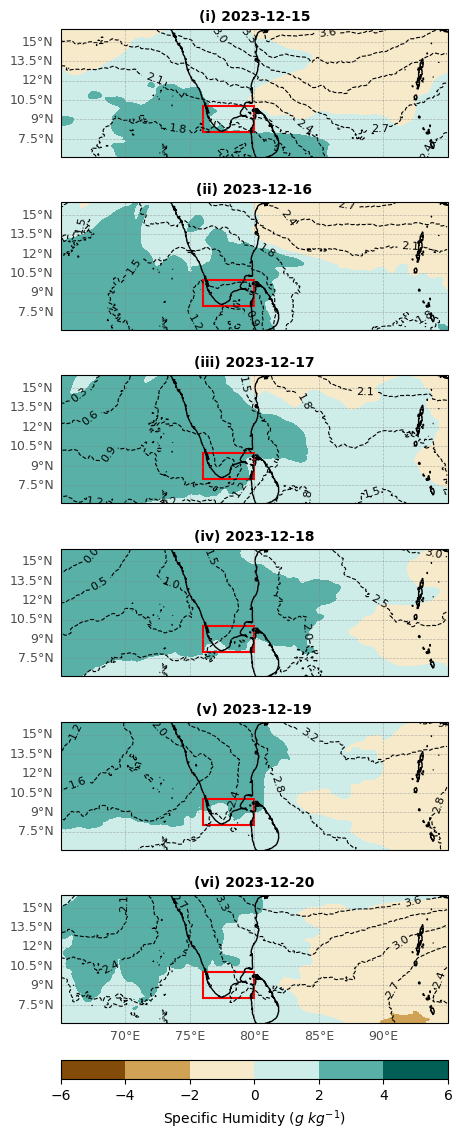

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from glob import glob
from matplotlib.patches import Rectangle
def load_julian_mean_sph(paths_mslp=None, paths_gph=None, height=500):
    """
    Load and process climate data to calculate Julian day means.
    """
    datasets_mslp = []
    for i, fp in enumerate(paths_mslp):
        ds = xr.open_dataset(fp)
    
        # Select the specific height level if available
        if 'lev' in ds.dims:
            ds = ds.sel(lev=height)
        
        # Drop variables only if necessary
        if i >= 30 and {'lon', 'lat'}.issubset(ds.variables):
            ds = ds.drop_vars(['lon', 'lat'])
                # Harmonize coordinate names
            if 'longitude' in ds.coords:
                ds = ds.rename({'longitude': 'lon'})
            if 'latitude' in ds.coords:
                ds = ds.rename({'latitude': 'lat'})
        # Align coordinates to a reference grid
        if i == 0:
            # Use the first dataset as a reference grid
            ref_lat = ds['lat']
            ref_lon = ds['lon']
        else:
            ds = ds.interp(lat=ref_lat, lon=ref_lon, method="nearest")
        if(i>31):
               ds.to_netcdf(f"C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/sph_{height}_{i}.nc")
        datasets_mslp.append(ds)

    # Concatenate along time dimension
    data_mslp = xr.concat(datasets_mslp, dim="time")
    data_mslp['time'] = pd.to_datetime(data_mslp['time'].values)
    data_mslp = data_mslp.assign_coords(julian_day=data_mslp['time'].dt.dayofyear)
    julian_mean_mslp = data_mslp['sph'].groupby('julian_day').mean(dim='time')
    
    # Load GPH data
    datasets_gph = []
    for fp in paths_gph:
        ds = xr.open_dataset(fp)
        # Select the specific height level first
        if 'plevel' in ds.dims:
            ds = ds.sel(plevel=height)
        datasets_gph.append(ds)
    
    # Concatenate along time dimension
    data_gph = xr.concat(datasets_gph, dim="time")
    data_gph['time'] = pd.to_datetime(data_gph['time'].values)
    data_gph = data_gph.assign_coords(julian_day=data_gph['time'].dt.dayofyear)
    julian_mean_gph = data_gph['HGT_prl'].groupby('julian_day').mean(dim='time')
    
    return julian_mean_mslp, julian_mean_gph

# Load Julian Mean values
paths_mslp = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/SPH/sph*.nc"))
#paths_mslp.extend(sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/data/SPH_Scaled/sph*.nc")))
paths_gph = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum*.nc"))
julian_mean, julian_mean_gph = load_julian_mean_sph(paths_mslp=paths_mslp, paths_gph=paths_gph)



def plot_sph_with_gph_anomaly(
    data_path="C://Users/sreega/Desktop/Workstation/EPE_Identification/decEPE/IMDAA/sph_500_32.nc",
    gph_path="C://Users/sreega/Desktop/Workstation/EPE_Identification/decEPE/IMDAA/data/GPH/ncum_imdaa_reanl_HR_HGT-prl_2023121500-2023122121.nc",
    julian_mean=None,
    julian_mean_gph=None,
    date_range=[f"2023-12-{j}" for j in range(15, 21)],
    height=500,
    output_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/Figures/SPH_GPH_500.png"
    ):
        
    # Read the datasets
    data = xr.open_dataset(data_path)
    data_gph = xr.open_dataset(gph_path)
    # Define tick intervals 
    yticks = np.arange(5, 21, 3)

    # Set lat/lon bounds
    min_lon, max_lon = 65, 95
    min_lat, max_lat = 6.1, 16

    # Create the figure and axes for subplots
    fig, axes = plt.subplots(nrows=len(date_range), ncols=1, figsize=(5, 16),subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Shared colorbar parameters
    cmap = 'BrBG'
    labels=['(i)', '(ii)', '(iii)', '(iv)', '(v)', '(vi)']
    # Ensure axes is a list for compatibility
    if len(date_range) == 1:
        axes = [axes]

    # Loop over dates
    for idx, date in enumerate(date_range):
        ax = axes[idx]
        
        # Select data for the specific date and region
        date_data = data.sel(
            time=date, 
            lat=slice(min_lat, max_lat), 
            lon=slice(min_lon, max_lon),
        )['sph'].squeeze()
        
        date_data_gph = data_gph.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon), 
            plevel=height
        )['HGT_prl'].squeeze()
        
        # Extract Julian day
        julian_day = pd.to_datetime(date).dayofyear
        
        # Subset Julian mean values for the specific day
        julian_mean_mslp = julian_mean.sel(
            julian_day=julian_day,
            lat=slice(min_lat, max_lat),
            lon=slice(min_lon, max_lon)
        ).squeeze()
        
        julian_mean_gph_day = julian_mean_gph.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        # Calculate anomalies
        mslp_anomaly = date_data - julian_mean_mslp  # No need to divide by 100 for Celsius
        gph_anomaly = (date_data_gph - julian_mean_gph_day) / 10
        
        # Ensure anomalies are 2D (lat, lon)
        if 'time' in mslp_anomaly.dims:
            mslp_anomaly = mslp_anomaly.mean(dim='time')*1000
        if 'time' in gph_anomaly.dims:
            gph_anomaly = gph_anomaly.mean(dim='time')

        # Create meshgrid for plotting
        lon, lat = np.meshgrid(mslp_anomaly.lon.values, 
                                mslp_anomaly.lat.values)
        # Plot MSLP anomaly
        cf = ax.contourf(lon, lat, mslp_anomaly.values, 
                        cmap=cmap,levels=[-6,-4,-2,0,2,4,6],
                        transform=ccrs.PlateCarree())
        
        # Plot GPH anomaly
        cs = ax.contour(lon, lat, gph_anomaly.values,
                        colors='black', linewidths=0.8, linestyles='dashed',
                        transform=ccrs.PlateCarree())
        
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.1f')
        
        # Add features to the map
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='#F5F5DC')
        ax.add_feature(cfeature.OCEAN, facecolor='#E0FFFF')
        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Add a rectangular box
        lon_min, lon_max = 76, 80
        lat_min, lat_max = 8, 10
        box = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                        edgecolor='red', facecolor='none', linewidth=1.5, transform=ccrs.PlateCarree())
        ax.add_patch(box)
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        gl.left_labels = True
        
        # Manually set left labels
        gl.ylabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Only show x-ticks on the last plot
        if idx == len(date_range)-1:
            gl.bottom_labels = True
            gl.xlabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Title for each subplot
        ax.set_title(f'{labels[idx]} {date}', fontsize=10,fontweight='bold')

    cbar = fig.colorbar(cf, ax=axes, orientation='horizontal', 
                    label="Specific Humidity ($g~kg^{-1}$)", pad=0.03)
    # Save the figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Plot anomalies
plot_sph_with_gph_anomaly(julian_mean=julian_mean, julian_mean_gph=julian_mean_gph)

# Specific Humidity 500 hPa

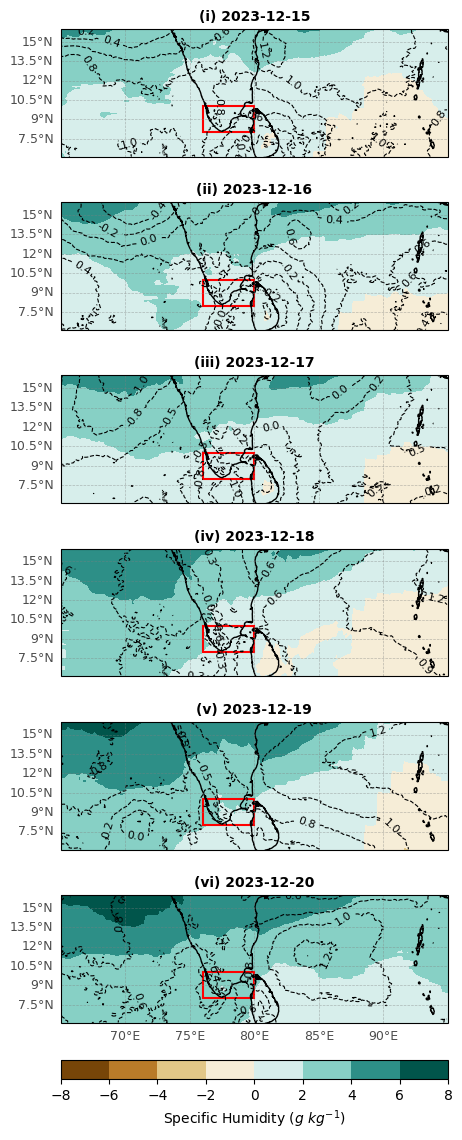

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from glob import glob
from matplotlib.patches import Rectangle
def load_julian_mean_sph(paths_mslp=None, paths_gph=None, height=850):
    """
    Load and process climate data to calculate Julian day means.
    """
    datasets_mslp = []
    for i, fp in enumerate(paths_mslp):
        ds = xr.open_dataset(fp)
    
        # Select the specific height level if available
        if 'lev' in ds.dims:
            ds = ds.sel(lev=height)
        
        # Drop variables only if necessary
        if i >= 30 and {'lon', 'lat'}.issubset(ds.variables):
            ds = ds.drop_vars(['lon', 'lat'])
                # Harmonize coordinate names
            if 'longitude' in ds.coords:
                ds = ds.rename({'longitude': 'lon'})
            if 'latitude' in ds.coords:
                ds = ds.rename({'latitude': 'lat'})
        # Align coordinates to a reference grid
        if i == 0:
            # Use the first dataset as a reference grid
            ref_lat = ds['lat']
            ref_lon = ds['lon']
        else:
            ds = ds.interp(lat=ref_lat, lon=ref_lon, method="nearest")
        if(i>31):
               ds.to_netcdf(f"C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/sph_{height}_{i}.nc")
        datasets_mslp.append(ds)

    # Concatenate along time dimension
    data_mslp = xr.concat(datasets_mslp, dim="time")
    data_mslp['time'] = pd.to_datetime(data_mslp['time'].values)
    data_mslp = data_mslp.assign_coords(julian_day=data_mslp['time'].dt.dayofyear)
    julian_mean_mslp = data_mslp['sph'].groupby('julian_day').mean(dim='time')
    
    # Load GPH data
    datasets_gph = []
    for fp in paths_gph:
        ds = xr.open_dataset(fp)
        # Select the specific height level first
        if 'plevel' in ds.dims:
            ds = ds.sel(plevel=height)
        datasets_gph.append(ds)
    
    # Concatenate along time dimension
    data_gph = xr.concat(datasets_gph, dim="time")
    data_gph['time'] = pd.to_datetime(data_gph['time'].values)
    data_gph = data_gph.assign_coords(julian_day=data_gph['time'].dt.dayofyear)
    julian_mean_gph = data_gph['HGT_prl'].groupby('julian_day').mean(dim='time')
    
    return julian_mean_mslp, julian_mean_gph

# Load Julian Mean values
paths_mslp = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/SPH/sph*.nc"))
#paths_mslp.extend(sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/data/SPH_Scaled/sph*.nc")))
paths_gph = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum*.nc"))
julian_mean, julian_mean_gph = load_julian_mean_sph(paths_mslp=paths_mslp, paths_gph=paths_gph)
julian_mean


def plot_sph_with_gph_anomaly(
    data_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/sph_850_32.nc",
    gph_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum_imdaa_reanl_HR_HGT-prl_2023121500-2023122121.nc",
    julian_mean=None,
    julian_mean_gph=None,
    date_range=[f"2023-12-{j}" for j in range(15, 21)],
    height=850,
    output_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/Figures/SPH_GPH_850.png"
    ):
        
    # Read the datasets
    data = xr.open_dataset(data_path)
    data_gph = xr.open_dataset(gph_path)
    # Define tick intervals 
    yticks = np.arange(5, 21, 3)

    # Set lat/lon bounds
    min_lon, max_lon = 65, 95
    min_lat, max_lat = 6.1, 16

    # Create the figure and axes for subplots
    fig, axes = plt.subplots(nrows=len(date_range), ncols=1, figsize=(5, 16),subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Shared colorbar parameters
    cmap = 'BrBG'
    labels=['(i)', '(ii)', '(iii)', '(iv)', '(v)', '(vi)']
    # Ensure axes is a list for compatibility
    if len(date_range) == 1:
        axes = [axes]

    # Loop over dates
    for idx, date in enumerate(date_range):
        ax = axes[idx]
        
        # Select data for the specific date and region
        date_data = data.sel(
            time=date, 
            lat=slice(min_lat, max_lat), 
            lon=slice(min_lon, max_lon),
        )['sph'].squeeze()
        
        date_data_gph = data_gph.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon), 
            plevel=height
        )['HGT_prl'].squeeze()
        
        # Extract Julian day
        julian_day = pd.to_datetime(date).dayofyear
        
        # Subset Julian mean values for the specific day
        julian_mean_mslp = julian_mean.sel(
            julian_day=julian_day,
            lat=slice(min_lat, max_lat),
            lon=slice(min_lon, max_lon)
        ).squeeze()
        
        julian_mean_gph_day = julian_mean_gph.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        # Calculate anomalies
        mslp_anomaly = date_data - julian_mean_mslp  # No need to divide by 100 for Celsius
        gph_anomaly = (date_data_gph - julian_mean_gph_day) / 10
        
        # Ensure anomalies are 2D (lat, lon)
        if 'time' in mslp_anomaly.dims:
            mslp_anomaly = mslp_anomaly.mean(dim='time')*1000
        if 'time' in gph_anomaly.dims:
            gph_anomaly = gph_anomaly.mean(dim='time')

        # Create meshgrid for plotting
        lon, lat = np.meshgrid(mslp_anomaly.lon.values, 
                                mslp_anomaly.lat.values)
        # Plot MSLP anomaly
        cf = ax.contourf(lon, lat, mslp_anomaly.values, 
                        cmap=cmap,levels=[-8,-6,-4,-2,0,2,4,6,8],
                        transform=ccrs.PlateCarree())
        
        # Plot GPH anomaly
        cs = ax.contour(lon, lat, gph_anomaly.values,
                        colors='black', linewidths=0.8, linestyles='dashed',
                        transform=ccrs.PlateCarree())
        
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.1f')
        
        # Add features to the map
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='#F5F5DC')
        ax.add_feature(cfeature.OCEAN, facecolor='#E0FFFF')
        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Add a rectangular box
        lon_min, lon_max = 76, 80
        lat_min, lat_max = 8, 10
        box = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                        edgecolor='red', facecolor='none', linewidth=1.5, transform=ccrs.PlateCarree())
        ax.add_patch(box)
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        gl.left_labels = True
        
        # Manually set left labels
        gl.ylabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Only show x-ticks on the last plot
        if idx == len(date_range)-1:
            gl.bottom_labels = True
            gl.xlabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Title for each subplot
        ax.set_title(f'{labels[idx]} {date}', fontsize=10,fontweight='bold')

    cbar = fig.colorbar(cf, ax=axes, orientation='horizontal', 
                    label="Specific Humidity ($g~kg^{-1}$)", pad=0.03)
    # Save the figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Plot anomalies
plot_sph_with_gph_anomaly(julian_mean=julian_mean, julian_mean_gph=julian_mean_gph)

# Temperature at 850 hPa

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from glob import glob
from matplotlib.patches import Rectangle

def load_julian_mean(paths_mslp=None, paths_gph=None, height=850):
    """
    Load and process climate data to calculate Julian day means.
    """
    # Load MSLP data
    datasets_mslp = []
    for fp in paths_mslp:
        ds = xr.open_dataset(fp)
        # Convert temperature from Kelvin to Celsius
        if 'TMP_prl' in ds.variables:
            ds['TMP_prl'] = ds['TMP_prl'] - 273.15
        # Select the specific height level first
        if 'plevel' in ds.dims:
            ds = ds.sel(plevel=height)
        datasets_mslp.append(ds)
    
    # Concatenate along time dimension
    data_mslp = xr.concat(datasets_mslp, dim="time")
    data_mslp['time'] = pd.to_datetime(data_mslp['time'].values)
    data_mslp = data_mslp.assign_coords(julian_day=data_mslp['time'].dt.dayofyear)
    julian_mean_mslp = data_mslp['TMP_prl'].groupby('julian_day').mean(dim='time')
    
    # Load GPH data
    datasets_gph = []
    for fp in paths_gph:
        ds = xr.open_dataset(fp)
        # Select the specific height level first
        if 'plevel' in ds.dims:
            ds = ds.sel(plevel=height)
        datasets_gph.append(ds)
    
    # Concatenate along time dimension
    data_gph = xr.concat(datasets_gph, dim="time")
    data_gph['time'] = pd.to_datetime(data_gph['time'].values)
    data_gph = data_gph.assign_coords(julian_day=data_gph['time'].dt.dayofyear)
    julian_mean_gph = data_gph['HGT_prl'].groupby('julian_day').mean(dim='time')
    
    return julian_mean_mslp, julian_mean_gph

# Load Julian Mean values
paths_mslp = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/TEMP/ncum*.nc"))
paths_gph = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum*.nc"))
julian_mean, julian_mean_gph = load_julian_mean(paths_mslp=paths_mslp, paths_gph=paths_gph)


def plot_mslp_with_gph_anomaly(
    data_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/TEMP/ncum_imdaa_reanl_HR_TMP-prl_2023121500-2023122121.nc",
    gph_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum_imdaa_reanl_HR_HGT-prl_2023121500-2023122121.nc",
    date_range=[f"2023-12-{j}" for j in range(15, 21)],
    julian_mean=None,
    julian_mean_gph=None,
    height=850,
    output_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/Figures/TEMP_GPH_850.png"
):
    # Read the datasets
    data = xr.open_dataset(data_path)
    data_gph = xr.open_dataset(gph_path)
    
    # Convert temperature from Kelvin to Celsius
    if 'TMP_prl' in data.variables:
        data['TMP_prl'] = data['TMP_prl'] - 273.15
    
    # Define tick intervals 
    yticks = np.arange(5, 21, 3)
    
    # Set lat/lon bounds
    min_lon, max_lon = 65, 95
    min_lat, max_lat = 6.1, 16
    
    # Create the figure and axes for subplots
    fig, axes = plt.subplots(
        nrows=len(date_range), ncols=1, figsize=(5,16), 
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Shared colorbar parameters
    cmap = 'coolwarm'
    labels=['(i)', '(ii)', '(iii)', '(iv)', '(v)', '(vi)']
    # Ensure axes is a list for compatibility
    if len(date_range) == 1:
        axes = [axes]
    
    # Loop over dates
    for idx, date in enumerate(date_range):
        ax = axes[idx]
        
        # Select data for the specific date and region
        date_data = data.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon),
            plevel=height
        )['TMP_prl'].squeeze()
        
        date_data_gph = data_gph.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon), 
            plevel=height
        )['HGT_prl'].squeeze()
        
        # Extract Julian day
        julian_day = pd.to_datetime(date).dayofyear
        
        # Subset Julian mean values for the specific day
        julian_mean_mslp = julian_mean.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        julian_mean_gph_day = julian_mean_gph.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        # Calculate anomalies
        mslp_anomaly = date_data - julian_mean_mslp  # No need to divide by 100 for Celsius
        gph_anomaly = (date_data_gph - julian_mean_gph_day) / 10
        
        # Ensure anomalies are 2D (lat, lon)
        if 'time' in mslp_anomaly.dims:
            mslp_anomaly = mslp_anomaly.mean(dim='time')
        if 'time' in gph_anomaly.dims:
            gph_anomaly = gph_anomaly.mean(dim='time')
        
        # Create meshgrid for plotting
        lon, lat = np.meshgrid(mslp_anomaly.longitude.values, 
                              mslp_anomaly.latitude.values)
        levels = [-4,-3,-2,-1,0,1,2,3,4]
        # Plot MSLP anomaly
        cf = ax.contourf(lon, lat, mslp_anomaly.values, 
                        cmap=cmap, levels = levels,
                        transform=ccrs.PlateCarree())
        
        # Plot GPH anomaly
        cs = ax.contour(lon, lat, gph_anomaly.values,
                       colors='black', linewidths=0.8, linestyles='dashed',
                       transform=ccrs.PlateCarree())
        
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.1f')
        
        # Add features to the map
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='#F5F5DC')
        ax.add_feature(cfeature.OCEAN, facecolor='#E0FFFF')
        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Add a rectangular box
        lon_min, lon_max = 76, 80
        lat_min, lat_max = 8, 10
        box = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                       edgecolor='red', facecolor='none', linewidth=1.5, transform=ccrs.PlateCarree())
        ax.add_patch(box)
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        gl.left_labels = True
        
        # Manually set left labels
        gl.ylabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Only show x-ticks on the last plot
        if idx == len(date_range)-1:
            gl.bottom_labels = True
            gl.xlabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Title for each subplot
        ax.set_title(f'{labels[idx]} {date}', fontsize=10,fontweight='bold')
        
        # Add a shared color bar
    
    cbar = fig.colorbar(cf,ax=axes,  orientation='horizontal',
                        label='Temperature ($^\circ C$)', pad=0.03)  
    # Save the figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Plot anomalies
plot_mslp_with_gph_anomaly(julian_mean=julian_mean, julian_mean_gph=julian_mean_gph)



# At 500hPa

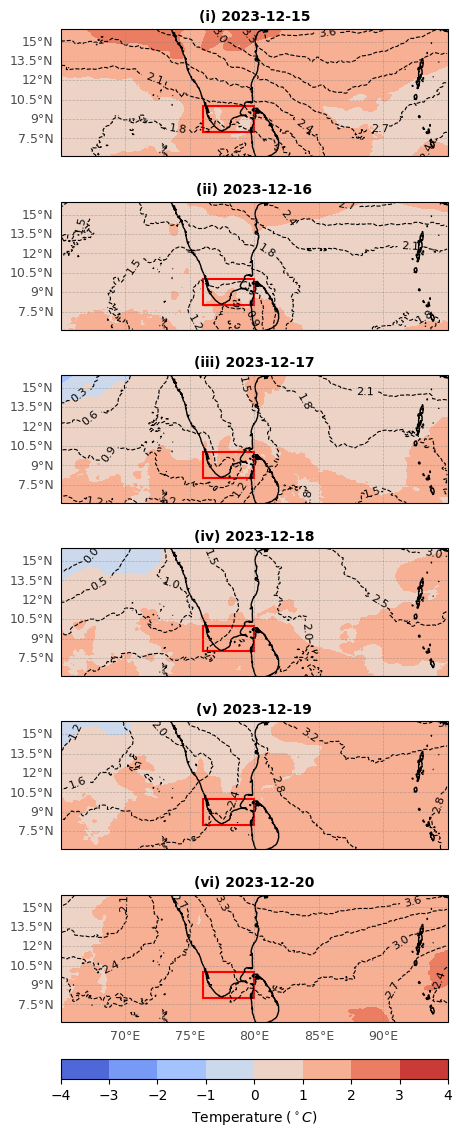

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from glob import glob
from matplotlib.patches import Rectangle

def load_julian_mean(paths_mslp=None, paths_gph=None, height=500):
    """
    Load and process climate data to calculate Julian day means.
    """
    # Load MSLP data
    datasets_mslp = []
    for fp in paths_mslp:
        ds = xr.open_dataset(fp)
        # Convert temperature from Kelvin to Celsius
        if 'TMP_prl' in ds.variables:
            ds['TMP_prl'] = ds['TMP_prl'] - 273.15
        # Select the specific height level first
        if 'plevel' in ds.dims:
            ds = ds.sel(plevel=height)
        datasets_mslp.append(ds)
    
    # Concatenate along time dimension
    data_mslp = xr.concat(datasets_mslp, dim="time")
    data_mslp['time'] = pd.to_datetime(data_mslp['time'].values)
    data_mslp = data_mslp.assign_coords(julian_day=data_mslp['time'].dt.dayofyear)
    julian_mean_mslp = data_mslp['TMP_prl'].groupby('julian_day').mean(dim='time')
    
    # Load GPH data
    datasets_gph = []
    for fp in paths_gph:
        ds = xr.open_dataset(fp)
        # Select the specific height level first
        if 'plevel' in ds.dims:
            ds = ds.sel(plevel=height)
        datasets_gph.append(ds)
    
    # Concatenate along time dimension
    data_gph = xr.concat(datasets_gph, dim="time")
    data_gph['time'] = pd.to_datetime(data_gph['time'].values)
    data_gph = data_gph.assign_coords(julian_day=data_gph['time'].dt.dayofyear)
    julian_mean_gph = data_gph['HGT_prl'].groupby('julian_day').mean(dim='time')
    
    return julian_mean_mslp, julian_mean_gph

# Load Julian Mean values
paths_mslp = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/TEMP/ncum*.nc"))
paths_gph = sorted(glob("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum*.nc"))
julian_mean, julian_mean_gph = load_julian_mean(paths_mslp=paths_mslp, paths_gph=paths_gph)


def plot_mslp_with_gph_anomaly(
    data_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/TEMP/ncum_imdaa_reanl_HR_TMP-prl_2023121500-2023122121.nc",
    gph_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/IMDAA/GPH/ncum_imdaa_reanl_HR_HGT-prl_2023121500-2023122121.nc",
    date_range=[f"2023-12-{j}" for j in range(15, 21)],
    julian_mean=None,
    julian_mean_gph=None,
    height=500,
    output_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/Figures/TEMP_GPH_500.png"
):
    # Read the datasets
    data = xr.open_dataset(data_path)
    data_gph = xr.open_dataset(gph_path)
    
    # Convert temperature from Kelvin to Celsius
    if 'TMP_prl' in data.variables:
        data['TMP_prl'] = data['TMP_prl'] - 273.15
    
    # Define tick intervals 
    yticks = np.arange(5, 21, 3)
    
    # Set lat/lon bounds
    min_lon, max_lon = 65, 95
    min_lat, max_lat = 6.1, 16
    
    # Create the figure and axes for subplots
    fig, axes = plt.subplots(
        nrows=len(date_range), ncols=1, figsize=(5,16), 
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Shared colorbar parameters
    cmap = 'coolwarm'
    labels=['(i)', '(ii)', '(iii)', '(iv)', '(v)', '(vi)']
    # Ensure axes is a list for compatibility
    if len(date_range) == 1:
        axes = [axes]
    
    # Loop over dates
    for idx, date in enumerate(date_range):
        ax = axes[idx]
        
        # Select data for the specific date and region
        date_data = data.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon),
            plevel=height
        )['TMP_prl'].squeeze()
        
        date_data_gph = data_gph.sel(
            time=date, 
            latitude=slice(min_lat, max_lat), 
            longitude=slice(min_lon, max_lon), 
            plevel=height
        )['HGT_prl'].squeeze()
        
        # Extract Julian day
        julian_day = pd.to_datetime(date).dayofyear
        
        # Subset Julian mean values for the specific day
        julian_mean_mslp = julian_mean.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        julian_mean_gph_day = julian_mean_gph.sel(
            julian_day=julian_day,
            latitude=slice(min_lat, max_lat),
            longitude=slice(min_lon, max_lon)
        ).squeeze()
        
        # Calculate anomalies
        mslp_anomaly = date_data - julian_mean_mslp  # No need to divide by 100 for Celsius
        gph_anomaly = (date_data_gph - julian_mean_gph_day) / 10
        
        # Ensure anomalies are 2D (lat, lon)
        if 'time' in mslp_anomaly.dims:
            mslp_anomaly = mslp_anomaly.mean(dim='time')
        if 'time' in gph_anomaly.dims:
            gph_anomaly = gph_anomaly.mean(dim='time')
        
        # Create meshgrid for plotting
        lon, lat = np.meshgrid(mslp_anomaly.longitude.values, 
                              mslp_anomaly.latitude.values)
        levels = [-4,-3,-2,-1,0,1,2,3,4]
        # Plot MSLP anomaly
        cf = ax.contourf(lon, lat, mslp_anomaly.values, 
                        cmap=cmap, levels = levels,
                        transform=ccrs.PlateCarree())
        
        # Plot GPH anomaly
        cs = ax.contour(lon, lat, gph_anomaly.values,
                       colors='black', linewidths=0.8, linestyles='dashed',
                       transform=ccrs.PlateCarree())
        
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.1f')
        
        # Add features to the map
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='#F5F5DC')
        ax.add_feature(cfeature.OCEAN, facecolor='#E0FFFF')
        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Add a rectangular box
        lon_min, lon_max = 76, 80
        lat_min, lat_max = 8, 10
        box = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                       edgecolor='red', facecolor='none', linewidth=1.5, transform=ccrs.PlateCarree())
        ax.add_patch(box)
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        gl.left_labels = True
        
        # Manually set left labels
        gl.ylabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Only show x-ticks on the last plot
        if idx == len(date_range)-1:
            gl.bottom_labels = True
            gl.xlabel_style = {'fontsize': 9, 'alpha': 0.7}
        
        # Title for each subplot
        ax.set_title(f'{labels[idx]} {date}', fontsize=10,fontweight='bold')
        
        # Add a shared color bar
    
    cbar = fig.colorbar(cf,ax=axes,  orientation='horizontal',
                        label='Temperature ($^\circ C$)', pad=0.03)  
    # Save the figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Plot anomalies
plot_mslp_with_gph_anomaly(julian_mean=julian_mean, julian_mean_gph=julian_mean_gph)

